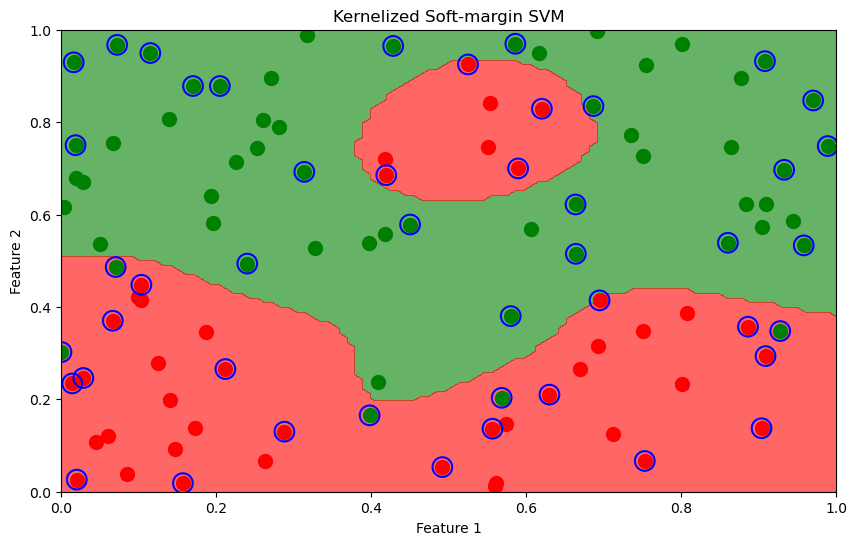

In [ ]:
# CS771 (Autumn 2023)
# Soft-margin nonlinear (kernelized) SVM by solving the dual problem (which is a quadratic program
# \alpha^\top 1 - 0.5 \alpha^\top G \alpha). To solve the QP (a convex maximization problem), we use the cvxopt package
# Note: The hyperparameters C and gamma are set by hand to show a reasonable-looking decision boundary
# (in practice, these hyperparameters are tuned using cross-validation; packages like sklearn provide ways to do it automatically)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Data generation functions
def get_data(lower, upper, num, num_dims):
    return np.random.uniform(lower, upper, size=(num, num_dims))

def get_labels(X):
    Y = []
    for x1, x2 in X:
        if x2 < np.sin(10 * x1) / 5 + 0.3 or ((x2 - 0.8) ** 2 + (x1 - 0.5) ** 2) < 0.15 ** 2:
            Y.append(1)
        else:
            Y.append(-1)
    return np.asarray(Y)


# Function to compute the RBF (Gaussian) kernel matrix
def rbf_kernel_matrix(X1, X2=None, gamma=1.0):
    """
    Compute the pairwise RBF kernel matrix between two feature matrices X1 and X2.

    Parameters:
    - X1: N1xD feature matrix (N1 samples, D dimensions)
    - X2: N2xD feature matrix (N2 samples, D dimensions) or None (default: X1)
    - gamma: Kernel parameter (controls the "spread" of the kernel)

    Returns:
    - K: N1xN2 kernel matrix
    """
    if X2 is None:
        X2 = X1

    N1 = X1.shape[0]
    N2 = X2.shape[0]
    K = np.zeros((N1, N2))

    for i in range(N1):
        for j in range(N2):
            # Compute the RBF kernel value between X1[i] and X2[j]
            K[i, j] = np.exp(-gamma * np.linalg.norm(X1[i] - X2[j])**2)

    return K

# Generate random data and labels
np.random.seed(1)

N = 100
X = get_data(0, 1, N, 2)
y = get_labels(X).reshape(-1)


# Regularization parameter (C) for soft-margin SVM
# Higher value of C means fewer examples violating the constraints (thus closer to hard-margin SVM)
C = 5

# Compute the RBF kernel matrix with a specific gamma value
gamma = 50  # You can adjust this parameter
K = rbf_kernel_matrix(X, X, gamma)

# Number of data points
N = X.shape[0]

# Compute the Gram matrix
Gtmp = K * np.outer(y, y)
G = cvxopt.matrix(Gtmp)
q = cvxopt.matrix(-np.ones(N))
# M and h specify alpha_i >= 0 constraints (M*alpha <= h)
M = cvxopt.matrix(np.vstack([-np.eye(N), np.eye(N)]))
h = cvxopt.matrix(np.hstack([np.zeros(N), C * np.ones(N)]))
# A and d specify sum(alpha_i * y_i) = 0 constraint (A*alpha = d)
A = cvxopt.matrix(y.reshape(1, -1), tc='d')
d = cvxopt.matrix(0.0)


# Solve the quadratic programming problem
cvxopt.solvers.options['show_progress'] = False
solution = cvxopt.solvers.qp(G, q, M, h, A, d)

# Extract the Lagrange multipliers
alpha_optimal = np.array(solution['x']).flatten()

# Find the support vectors
support_vector_indices = np.where((alpha_optimal > 1e-5) & (alpha_optimal < C))[0]
support_vectors = X[support_vector_indices]
support_vector_labels = y[support_vector_indices]
alpha_support_vectors = alpha_optimal[support_vector_indices[0]]

# Calculate b using one of the support vectors on the margin boundary (where alpha is exactly C)
margin_boundary_indices = np.where(np.abs(alpha_optimal - C) < 1e-5)[0]
chosen_support_vector = support_vectors[margin_boundary_indices[0]]
chosen_support_vector_label = support_vector_labels[margin_boundary_indices[0]]

# Calculate b using the chosen support vector and its label
b = chosen_support_vector_label - np.sum(alpha_support_vectors * support_vector_labels * rbf_kernel_matrix(np.array([chosen_support_vector]), support_vectors, gamma))

# Create a 2D grid for visualization
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
grid = np.c_[xx.ravel(), yy.ravel()]

# Calculate the decision function values for the grid points
Z = np.dot(rbf_kernel_matrix(grid, support_vectors, gamma), (alpha_support_vectors * support_vector_labels)) + b
Z = Z.reshape(xx.shape)

# Convert decision values to class labels (-1 or 1)
Z = np.sign(Z)


# Define a custom colormap
custom_cmap = ListedColormap(['green', 'red'])

# Plot the decision boundary using the custom colormap
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.6, levels=[-1, 0, 1])

# Scatter plot for class 1 (red)
class_1_indices = np.where(y == 1)[0]
plt.scatter(X[class_1_indices, 0], X[class_1_indices, 1], color=colors[1], marker='o', s=100)

# Scatter plot for class -1 (green)
class_minus_1_indices = np.where(y == -1)[0]
plt.scatter(X[class_minus_1_indices, 0], X[class_minus_1_indices, 1], color=colors[-1], marker='o', s=100)

# Scatter plot for support vectors with blue outline
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=200, facecolors='none', edgecolors='blue', linewidths=1.5, label='Support Vectors')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Kernelized Soft-margin SVM')
plt.show()